In [1]:
# Importing the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import re
import time
import datetime
import collections

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Flatten
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

In [2]:
tweet = pd.read_csv("Tweets.csv")

In [3]:
# Displaying the top 5 entries

tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Discover missing data for each column

(len(tweet)-tweet.count())/len(tweet)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [5]:
# Remove columns that have high ratio of missing values

tweet.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis=1, inplace=True ) 

In [6]:
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
tweet.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
Sentiment_mood = tweet['airline_sentiment'].value_counts()

Text(0.5, 1.0, 'Sentiment Model count')

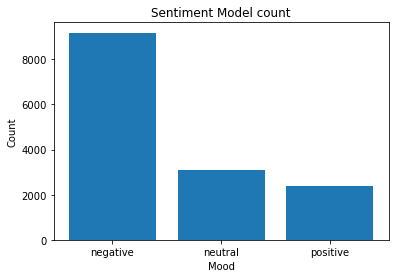

In [9]:
# Plotting the sentiment counts of positive, negative and neutral reasons

plt.bar([1,2,3],Sentiment_mood)
plt.xticks([1,2,3], ['negative','neutral','positive'],rotation=0)
plt.ylabel('Count')
plt.xlabel('Mood')
plt.title('Sentiment Model count')

In [10]:
#Airline-wise value count 

tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [11]:
# Function used to plot the Sentiment Moods of different airlines

def plot_Airline_sentiment(Airline):
    df = tweet[tweet['airline']==Airline]
    count  =df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Sentiment  Moods of '+Airline)

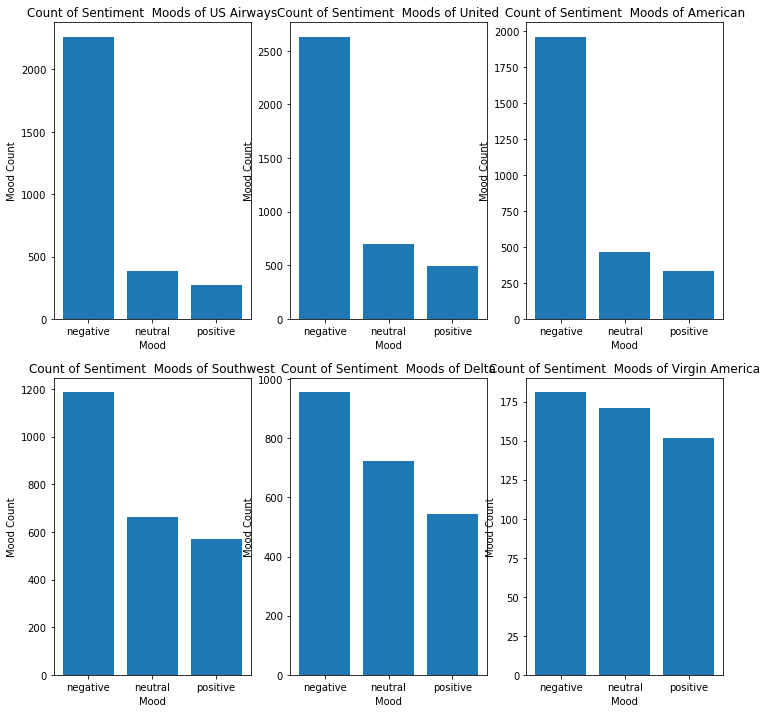

In [12]:
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_Airline_sentiment('US Airways')
plt.subplot(232)
plot_Airline_sentiment('United')
plt.subplot(233)
plot_Airline_sentiment('American')
plt.subplot(234)
plot_Airline_sentiment('Southwest')
plt.subplot(235)
plot_Airline_sentiment('Delta')
plt.subplot(236)
plot_Airline_sentiment('Virgin America')

In [13]:
nr_Count=dict(tweet['negativereason'].value_counts(sort=False))

In [14]:
# Function used to get unique negative reasons and make a new column

def nr_Count():
    df = tweet
    count = dict(df['negativereason'].value_counts())
    Unique_reason = list(tweet['negativereason'].unique())
    Unique_reason = [x for x in Unique_reason if str(x) != 'nan']
    Reason_frame = pd.DataFrame({'Reasons':Unique_reason}) 
    Reason_frame['count'] = Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
# Function used to plot the frequency of each of the unique reasons

def plot_reason():
    df = nr_Count()
    count = df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons ')

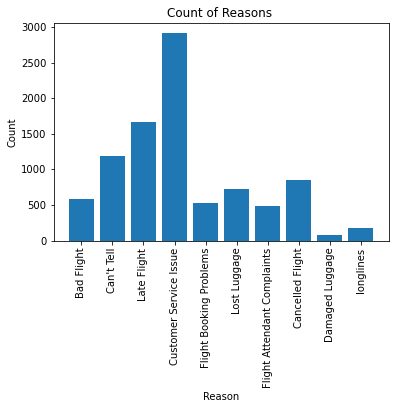

In [15]:
plot_reason()

In [16]:
# Cleaning the tweets

df = tweet[tweet['airline_sentiment'] == 'negative']
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [17]:
# Creating a Wordcloud object which contains the words used in the reasons, their size represent their frequency.

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)


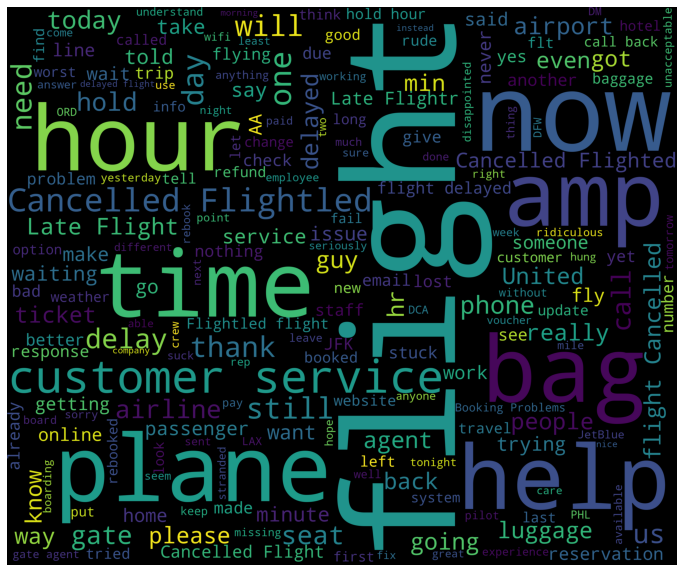

In [18]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [19]:
# Creating a list of NLTK stopwords

stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [20]:
# Function used to clean the tweets and the unnecessary airline names

def Cleaning_tweets(tweets):
    non_letters_removed = re.sub("[^a-zA-Z]", " ", tweets) 
    words = non_letters_removed.lower().split()                                              
    stop_words_removed = [w for w in words if not w in stop_words]
    airline_name_removed = [w for w in stop_words_removed if w not in ['virginamerica', 'united', 'southwest', 'delta', 'usairways', 'american']]
    return ( " ".join( airline_name_removed ))                                               

In [21]:
# Assigning each tweet, a sentiment of 0 if it is negative, else 1 for positive

tweet['sentiment'] = tweet['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [22]:
# Cleaning the tweets and separating each word by a space

tweet['cleaned_tweet'] = tweet['text'].apply(lambda x: Cleaning_tweets(x))
tweet['Tweet_length'] = tweet['cleaned_tweet'].apply(lambda x: len(x.split(' ')))

In [23]:
# Displaying the new dataframe formed

tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,sentiment,cleaned_tweet,Tweet_length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1,dhepburn said,2
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1,plus ve added commercials experience tacky,6
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1,didn today must mean need take another trip,8
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0,really aggressive blast obnoxious entertainmen...,10
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0,really big bad thing,4


In [24]:
# Creating train and test data

train,test = train_test_split(tweet, test_size=0.2, random_state=42)

In [25]:
# Making train and test data using the data from the 'cleaned_tweet' column

train_data = train.cleaned_tweet.values
test_data = test.cleaned_tweet.values

In [26]:
vector = CountVectorizer(analyzer = "word")
train_features = vector.fit_transform(train_data)
test_features= vector.transform(test_data)

In [27]:
# Creating a list of classifier models

Classifiers = [
    LogisticRegression(C=0.000000001, solver='liblinear', max_iter=200),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

In [28]:
# Training the model on each of the classifier from the array and then printing their accuracies

train_to_array = train_features.toarray()
test_to_array = test_features.toarray()
Accuracy = []
Model = []
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(train_to_array, train['sentiment'])
        pred = fit.predict(test_to_array)
    accuracy = accuracy_score(pred, test['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))

Accuracy of LogisticRegressionis 0.6451502732240437
Accuracy of SVCis 0.7332650273224044
Accuracy of DecisionTreeClassifieris 0.7636612021857924
Accuracy of RandomForestClassifieris 0.8152322404371585
Accuracy of AdaBoostClassifieris 0.7800546448087432
Accuracy of GaussianNBis 0.5741120218579235


Text(0.5, 1.0, 'Accuracies of Models')

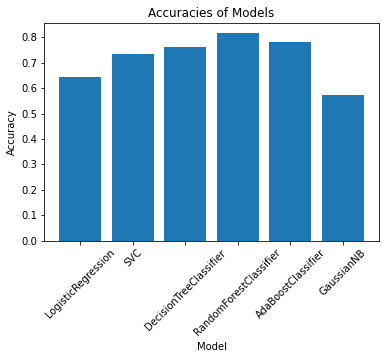

In [29]:
# Plotting a bar graph to represent the accuracy of each of the classifiers

Index = [1,2,3,4,5,6]
plt.bar(Index,Accuracy)
plt.xticks(Index, Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models') 

In [30]:
# Creating the global variables which will be used thorughtout the rest of the code

MAX_LEN = 40
NUM_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
EPOCHS = 40  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

In [31]:
# Creating train and test data from the cleaned tweets column

data_x = train.cleaned_tweet.values
data_y = train['sentiment'].values

In [32]:
# Splitting the train and test data

X_train, X_test, y_train, y_test = train_test_split(train['cleaned_tweet'], train['sentiment'], test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 10540
# Test data samples: 1172


In [33]:
X_train.shape

(10540,)

In [34]:
# Creating a tokenizer object

tokenizer = Tokenizer(num_words=NUM_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tokenizer.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tokenizer.document_count))
print('{} words in dictionary'.format(tokenizer.num_words))
print('Top 5 most common words are:', collections.Counter(tokenizer.word_counts).most_common(5))

Fitted tokenizer on 10540 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 2812), ('americanair', 2170), ('southwestair', 1763), ('jetblue', 1707), ('get', 959)]


In [35]:
# Converting train and test data into sequences

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [36]:
print(len(X_train_seq))

10540


In [37]:
# Function used to convert the sequences into one-hot encoding vectors

def one_hot_seq(seqs, nb_features=NUM_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[1222, 22, 281, 1655, 257, 180, 231, 776, 180, 182, 1, 28]" is converted into [0. 1. 0. ... 0. 0. 0.]
For this example we have 11.0 features with a value of 1.


In [38]:
X_train_oh.shape

(10540, 10000)

In [39]:
#Convert the labels to one hot encoding vector for softmax for neural network

num_labels = len(np.unique(y_train))
Y_oh_train = to_categorical(y_train, num_labels)
Y_oh_test = to_categorical(y_test, num_labels)
print(Y_oh_train.shape)

(10540, 2)


In [40]:
Y_oh_train[0:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [41]:
# Creating train and validation data for a simple deep learning model

X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_oh, Y_oh_train, test_size=0.1, random_state=37)
print('Shape of validation set:',X_train_2.shape)

Shape of validation set: (9486, 10000)


In [42]:
len(X_train_2[0])

10000

In [43]:
# Callbacks
# Deep Learning Callbacks - Keras

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1)


callbacks = [reduce_lr]

In [44]:
def compile_and_fit(model):
    model.compile(optimizer='rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train_2
                       , y_train_2
                       , epochs=EPOCHS
                       , batch_size=BATCH_SIZE
                       , callbacks=callbacks
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    
    return history

def dense_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(NUM_WORDS,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.summary()
    return model

def LSTM_model():
    
    model = models.Sequential()
    
    model.add(Embedding(NUM_WORDS, 100, input_length=MAX_LEN))
    
    model.add(LSTM(64, recurrent_dropout=0.2))    

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    

    model.add(Dense(2, activation='softmax'))
  
    model.summary()
    return model

In [45]:
model = dense_model()
model_history = compile_and_fit(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 1,288,514
Trainable params: 1,288,514
Non-trainable params: 0
_________________________________________________________________
Train on 9486 samples, validate on 1054 samples
Epoch 1/40
9486/9486 [==============================] - 2s 255us/sample - loss: 0.5407 - accuracy: 0.7224 - val_loss: 0.4359 - val_accuracy: 0.8121
Epoch 2/40
9486/9486 [==============================] - 1s 123us/sample - loss: 0.3287 - accuracy: 0.8741 - val_loss: 0.3849 - val_accuracy: 0.8216
Epoch 3/40
9216/9486 [==========

Epoch 26/40
9216/9486 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9653
Epoch 00026: ReduceLROnPlateau reducing learning rate to 5.960464760645934e-11.
9486/9486 [==============================] - 1s 121us/sample - loss: 0.1102 - accuracy: 0.9651 - val_loss: 0.4382 - val_accuracy: 0.8216
Epoch 27/40
9216/9486 [============================>.] - ETA: 0s - loss: 0.1105 - accuracy: 0.9647
Epoch 00027: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.
9486/9486 [==============================] - 1s 121us/sample - loss: 0.1102 - accuracy: 0.9651 - val_loss: 0.4382 - val_accuracy: 0.8216
Epoch 28/40
9216/9486 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9650
Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.4901161901614834e-11.
9486/9486 [==============================] - 1s 120us/sample - loss: 0.1102 - accuracy: 0.9651 - val_loss: 0.4382 - val_accuracy: 0.8216
Epoch 29/40
9216/9486 [============================

In [46]:
# Function to plot the evaluation of the model with respect to accuracy

def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

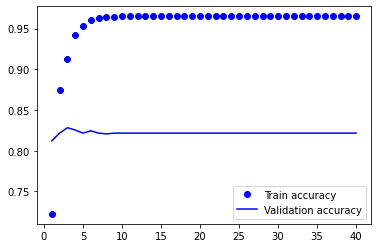

In [47]:
eval_metric(model_history, 'accuracy')

In [48]:
# Plotting the performance of the model

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+str(datetime.datetime.today()), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+str(datetime.datetime.today()), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [49]:
# Modify sequence model to max 25 in length

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_deep = sequence.pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_deep = sequence.pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [50]:
# Split data for LSTM model
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train_deep, Y_oh_train, test_size=0.1, random_state=37)


print('Shape of validation set:',X_train_2.shape)

Shape of validation set: (9486, 40)


In [52]:
model = LSTM_model()
model_history = compile_and_fit(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

Epoch 35/40
9216/9486 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.9229
Epoch 00035: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
9486/9486 [==============================] - 3s 325us/sample - loss: 0.1976 - accuracy: 0.9227 - val_loss: 0.4135 - val_accuracy: 0.8178
Epoch 36/40
9216/9486 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.9224
Epoch 00036: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
9486/9486 [==============================] - 3s 323us/sample - loss: 0.2002 - accuracy: 0.9229 - val_loss: 0.4181 - val_accuracy: 0.8178
Epoch 37/40
9216/9486 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9169
Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
9486/9486 [==============================] - 3s 319us/sample - loss: 0.2046 - accuracy: 0.9174 - val_loss: 0.4231 - val_accuracy: 0.8169
Epoch 38/40
9216/9486 [===========================

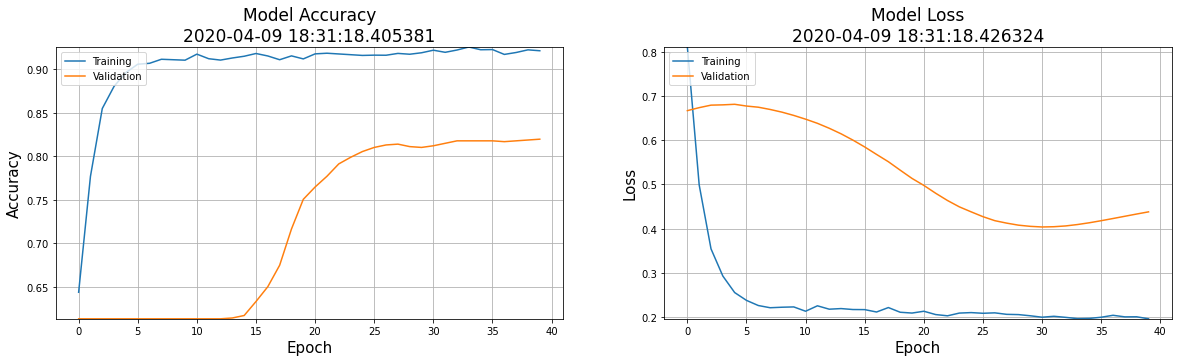

In [53]:
plot_performance(history=model_history)

In [55]:
# Testing our LSTM Model sentiment analysis on a sample statement

sample = ['Meetings: Air crew is so bad.']
sample = tokenizer.texts_to_sequences(sample)
sample = sequence.pad_sequences(sample, maxlen=MAX_LEN)
# print(sample)
sentiment = model.predict(sample, batch_size=1, verbose = 2)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

1/1 - 0s
negative
